## 章節 6：決策分析（Dicision Analysis）

### 6.5 對參賽者建模

下圖的是之前所有可能價格的分佈情況。如果你是參賽者，你可以用這個分佈作為你對於價格先驗信念。（**在你還沒看到展示品之前**）

展示品 1 價格總數 313 比
展示品 2 價格總數 313 比


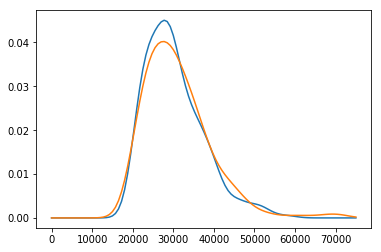

In [35]:
from thinkbayes import EstimatedPdf, Pmf, MakeCdfFromList, GaussianPdf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_pmf(pmf):
    x, y = zip(*sorted(pmf.Items()))
    plt.plot(x, y)


def simple_read_col(file, col_name):
    df = pd.read_csv(file, index_col=0).T
    return df[col_name].astype(int).values

    
def simple_read_prices(file, showcase=1):
    col_name = "Showcase %d" % showcase        
    return simple_read_col(file, col_name)



def get_all_prices(showcase=1): # 先不考慮效率
    data = ["showcases.2011.csv", "showcases.2012.csv"]
    return np.concatenate([simple_read_prices(file, showcase) for file in data])


def plot_kde_prices(showcase=1):
    prices = get_all_prices(showcase)
    print("展示品", showcase, "價格總數", prices.size, "比")
    pdf = EstimatedPdf(prices)

    low, high = 0, 75000
    n = 101
    xs = np.linspace(low, high, n)
    pmf = pdf.MakePmf(xs)
    plot_pmf(pmf)
    
plot_kde_prices(1)
plot_kde_prices(2)

要更新此先驗分佈，我們需要回答下列問題：

1. 我們需要考慮什麼**資料**並且怎麼量化它？
2. 定義一個似然性函數；對每個可能的價格，我們能計算從**資料**計算其條件似然性（conditional likelihood）嗎？

為了回答上述問題，我將參賽者當作一個知道誤差的猜價格機器。換句話說，當參賽者看到展示品，他或她對展示品出價就稱作 guess。

在這個模型下，我們必須回答一個問題：「如果實際價格為 price ，參賽者猜測為 guess 元的可能性是多少？」，或是定義為：

$$ error=price-guess $$

接著我們問：「參賽者估計 error 的可能性是多大？」。為了回答此問題，我們又用了一次歷史資料。

下圖是過去參賽者出價與真實價格差異 diff 的累積密度分佈(CDF)。diff 的定義為:

$$ \text{diff}=price-bid $$

當 diff 是負的則表示猜賽者出價過高，反之 diff 為正的則參賽者出價過低。

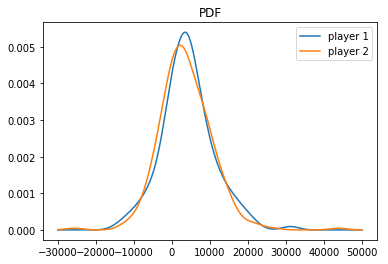

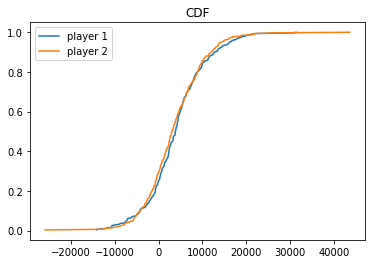

參賽者 1 出價過高的機率 0.24600638977635783
參賽者 2 出價過高的機率 0.29073482428115016


In [34]:

def simple_read_diff(file, showcase=1):
    col_name = "Difference %d" % showcase        
    return simple_read_col(file, col_name)
    
    
def get_all_diff(showcase=1): # 先不考慮效率
    data = ["showcases.2011.csv", "showcases.2012.csv"]
    return np.concatenate([simple_read_diff(file, showcase) for file in data])


def make_pmf(data):
    pdf = EstimatedPdf(data)
    low, high = -30000, 50000
    n = 1001
    xs = np.linspace(low, high, n)
    pmf = pdf.MakePmf(xs)
    return pmf
    
    
showcase1_diff_pmf = make_pmf(get_all_diff(1))
showcase2_diff_pmf = make_pmf(get_all_diff(2))


plot_pmf(showcase1_diff_pmf)
plot_pmf(showcase2_diff_pmf)
plt.legend(["player 1", "player 2"])
plt.title("PDF") # 機率密度函數
plt.show()


#cdf1 = showcase1_diff_pmf.MakeCdf()
#cdf2 = showcase2_diff_pmf.MakeCdf()
cdf1 = MakeCdfFromList(get_all_diff(1))
cdf2 = MakeCdfFromList(get_all_diff(2))
plot_pmf(cdf1)
plot_pmf(cdf2)
plt.legend(["player 1", "player 2"])
plt.title("CDF") # 累積密度函數
plt.show()

print("參賽者 1 出價過高的機率", cdf1.Prob(0))
print("參賽者 2 出價過高的機率", cdf2.Prob(0))

我們可以用上面的 CDF 分佈來計算參賽者出價過高的機率：參賽者 1 出價過高的機率約 26%，參賽者 2 出價過高的機率約 29%。

我們也可以看到參賽者的出價是有偏向的；也就是他們傾向於出價低而非出較高。這也很合理，看遊戲規則就知道。

最後，我們可以用此分佈預測參賽者出價的可靠度。這步驟很弔詭，因為我們不真的知道參賽者當下的猜想(guess)；我們只知道他的出價(bid)。

所以我們將要用一些假設。其中我假設 error (= price - guess)的分佈是服從一個高斯分佈其：

- 平均值：0
- 標準差：diff (= price-bid)

接著我們實作 Player 類別來表示這個模型：

In [39]:
class Player(object):
    
    def __init__(self, prices, bids, diffs):
        # prices: 真實價格的序列
        # bids: 參賽者出價的序列
        # diffs: 價差的序列
        
        # 平滑化版本的真實價格分佈
        self.pdf_price = EstimatedPdf(prices)
        
        # diff 的累積機率分佈，如上圖的 CDF
        self.cdf_diff = MakeCdfFromList(diffs)
        
        mu = 0
        sigma = numpy.std(diffs)
        
        # 價差的高斯分佈
        self.pdf_error = GaussianPdf(mu, sigma)

在申明一次，用 diff 的方差來估計 error 方差固然不完美，畢竟猜賽者的真實出價有時會策略；例如，如果參賽者2認為參賽者1出價過高，則參賽者2可能會出一個非常低的價格。在這種情況下 diff 就不能反映 error。如果這種情況發生很多次，則 diff 的方差可能會高估 error 的方差。

無論如何，這還是一個合理的模型選擇。

作為替代方案，準備要參加遊戲節目的人可以透過之前遊戲的資料來估計他們可能的猜測誤差。